In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
# torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True
import pathlib

In [146]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)
    
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if (pr is None or pr > thresh):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [131]:
BASE_DIR = pathlib.Path('/mnt/data/dataset/id_detection/id-detection-data')
ID = 'id'
FILE_NAME = 'filename'
BBOX = 'bbox'
CLAS = 'clas'
BASE_CSV = BASE_DIR / 'training/annotations.csv' # contains all information
TRN_CSV = BASE_DIR / 'training/annotations_bbox.csv' # contains only the bbox info
CLS_CSV = BASE_DIR / 'training/annotations_clas.csv' # contains only class info
IMAGES = 'training/dataset'
cats = ['ID'] # all categories
all_infos = pd.read_csv(BASE_CSV)
trn_fns = dict((o[ID], o[FILE_NAME]) for i, o in all_infos[[ID, FILE_NAME]].iterrows())
trn_ids = [o[ID] for i, o in all_infos.iterrows()]
id2cat = dict((i, c) for i, c in enumerate(cats))
cat2id = dict((v, k) for k,v in enumerate(cats))
mc = [set([r[CLAS]]) for i, r in all_infos.iterrows()]
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])
val_idxs = get_cv_idxs(len(all_infos))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

f_model=resnet34
sz=224
bs=64
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(BASE_DIR, IMAGES, TRN_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)


trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

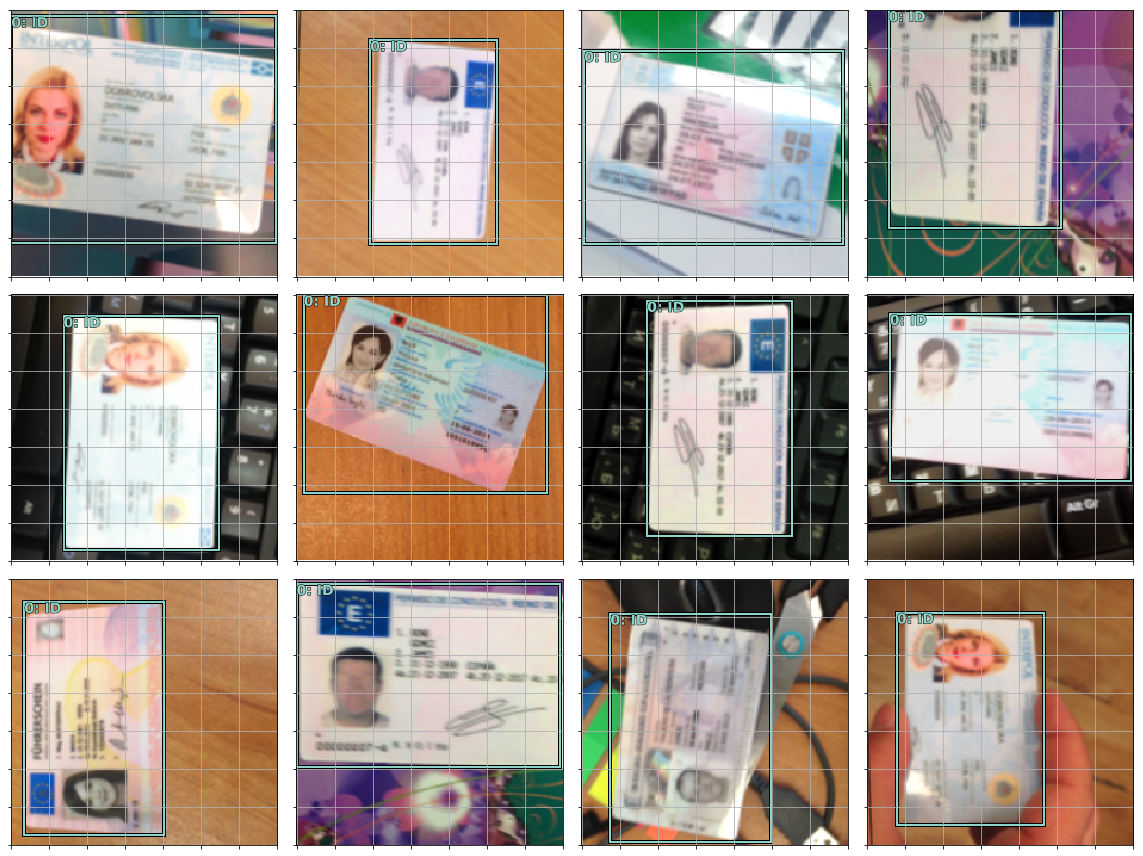

In [179]:
x,y=to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()


In [155]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)
n_clas = len(cats)+1
n_act = k*(4+n_clas)
n_clas, n_act

(2, 6)

In [164]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, n_clas*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
    

class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [251]:
def get_y(bbox,clas):
    """
    Keep only bounding boxes that class activation > 0. Correspondingly there are 
    14x4 = 56 box coordinates
    bbox: size (56,) of coordinates
    clas: size (14,) of classes
    Return the box coordinates resize to width/height of 1 and their corresponding classes
    """
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    """
    convert activation units into bounding boxes
    actn: (16,4) activation out of ???
    anchors: (16,4) list of anchor boxes of (center_x, center_y, width, height)
    return: (16, 4) for centers and w, h
    """
    actn_bbs = torch.tanh(actn)
    # remember that (x, y) in activation's (x, y, w, h) are the relative position to the anchor box center
    # we /2 here because it's defined that the gt box could be offset 1/2 grid size to the left or the the
    # right of the center of the anchor box. For example, x = 1 means that the center of predict box is 
    # on the far right of the anchor box, x = -1 means that the center of predict box is on the far left
    # of the anchor box. The '+' at the end is for the `relative part`. 
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    # likewise, the (w, h) are relative to the width and height of the anchor box. Here the defined range is:
    # when w = 1 => box's w = 1.5*anchor's width
    # when w = -1 => box's w = .5 * anchor's width
    # therefore the range of possible width is .5-1.5 anchor width
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    # convert activation bb in form (x, y, w, h) to (x1, y1, x2, y2)
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    """
    this step returns these numbers for each anchor box
    - the amount of overlaps with gt boxes, 1.99 means maximum overlap
    - the gt box with which each anchor box overlaps most
    
    overlaps: (x, 16) = amount of overlaps between activation bounding boxes and anchor boxes
    return:
        gt_overlap: (16,)
        gt_idx: (16,)
    
    """
    # for each gt box, find out which anchor box it overlaps most (1). This is
    # essentially "matches" those anchor boxes 1-to-1 to each gt object
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print('prior_overlap', prior_overlap.shape, prior_overlap)
    # for each anchor box, find out which gt box it overlaps with most (2). This is
    # for remaining unmatched anchor box, find the gt box with it has largest iou with. 
    # what results is that each gt object should have at least 1 matched anchor box, but 
    # some may have more than 1 matched anchor box.
    gt_overlap, gt_idx = overlaps.max(0)
    # for those anchor box in (1), mark them with maximum of value 1.99 for maximum overlap
    gt_overlap[prior_idx] = 1.99
    # for those anchor box in (2), mark them with the gt box they overlap most with from (1)
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    # get bbox with positive value
    bbox,clas = get_y(bbox,clas)
    # activate them and turn them into bounding boxes
    a_ic = actn_to_bb(b_bb, anchors)
    # calculate their overlaps with anchor boxes
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    # get the boxes that make sense
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    # get the classes of positive anchor boxes
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    # assign the rest of anchor boxes without any overlap to background
    # because let's say we have 20 classes with id from 0-19, then the 
    # class id of 20 is the background
    gt_clas[1-pos] = len(id2cat)
    # kind of duplicate the gt boxes into list of 16 boxes corresponding to the
    # 16 anchor boxes so that in the next line we could use the same indexing mechanism
    # to get the positive boxes locations
    gt_bbox = bbox[gt_idx]
    # calculate the location loss between anchor boxes and their corresponding calculated activation boxes
    # the # of row = number of gt boxes
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        # TODO: there's a case where bbox contains all 0
        try:
            loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
            lls += loc_loss
            lcs += clas_loss
        except:
#             print(b_bb, bbox)
            pass
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [ ]:
x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)
x.cuda()
for i,o in enumerate(y): y[i] = o.cuda()
learn.model.cuda()

In [225]:
batch = learn.model(x)
ssd_loss(batch, y, False)

Variable containing:
 117.0600
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [252]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

 79%|███████▉  | 49/62 [00:32<00:08,  1.49it/s, loss=1.2e+04] 

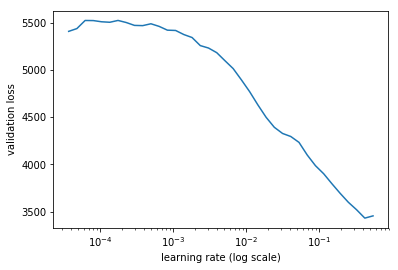

In [253]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [254]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

epoch      trn_loss   val_loss   
    0      1962.138821 526.34277 
    1      730.056798 232.599233
    2      378.170493 174.986648
    3      254.711759 149.07525 
    4      202.912697 143.487562


[array([143.48756])]

In [263]:
learn.fit(lr, 1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss   
    0      160.671602 114.538737
    1      127.935532 303.291369
    2      115.210547 94.74023  
    3      99.68503   921.04503 
    4      91.610042  101.721032
    5      83.488393  217.451231
    6      77.483151  79.027668 
    7      76.080966  71.464434 
    8      72.421501  69.763853 
    9      70.236609  158.77687 


[array([158.77687])]

In [ ]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

In [264]:
b_clas.size(),b_bb.size()

(torch.Size([64, 16, 2]), torch.Size([64, 16, 4]))

In [265]:
idx=7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

(Variable containing:
  0.1116  0.0000  0.5223  0.6562
 [torch.cuda.FloatTensor of size 1x4 (GPU 0)], Variable containing:
  0
 [torch.cuda.LongTensor of size 1 (GPU 0)])

In [266]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


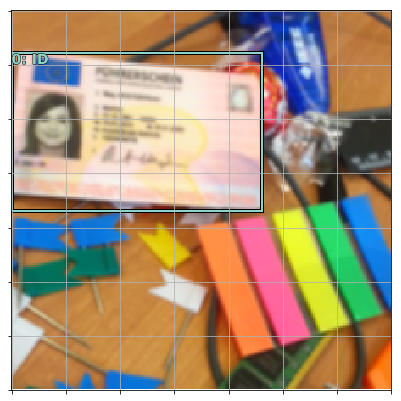

In [267]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


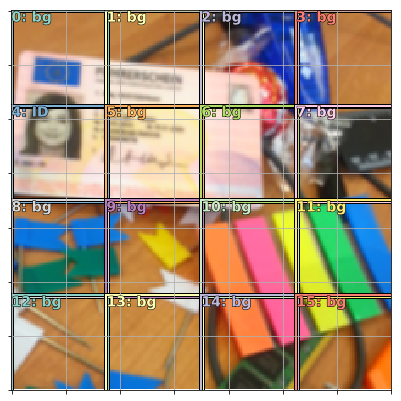

In [268]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


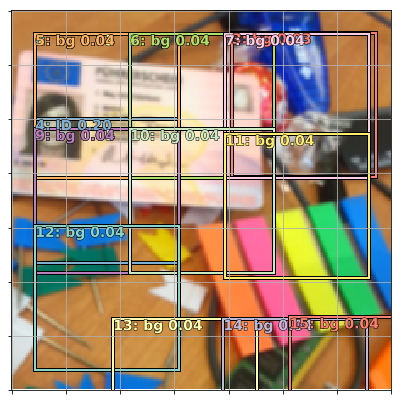

In [269]:
a_ic = actn_to_bb(b_bboxi, anchors)
a_ic
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)